**Problem Type:** Binary Classification

## Evaluation Metric


# XGBoost

This is based on a generic framework that I'm starting to develop.  Eventually, it will also support catboost, lgbm, and a Keras/TF DNN.

- https://www.kaggle.com/code/meetnagadia/titanic-random-forest-score-0-79471
- https://www.kaggle.com/code/adamml/my-spaceship-titanic-80-5



<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

In [1]:
import os
from pathlib import Path
import time
import gc

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import random
import pandas as pd
import numpy as np
import datatable as dt  # Fast table loading

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import LabelEncoder

# from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import mode

# GBDTs
# from xgboost import XGBClassifier, XGBRegressor
# from catboost import CatBoostClassifier

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Visualization Libraries
import matplotlib.pylab as plt
import seaborn as sns

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomUniform

import warnings

warnings.filterwarnings("ignore")

plt.style.use("fivethirtyeight")  # ggplot fivethirtyeight bmh
pd.options.display.max_columns = 500

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [2]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

In [3]:
class Config:
    path = "../input/titanic"
    gpu = False
    debug = False
    optimize = False
    n_optimize_trials = 5
    model_type = "xgb"  # (xgb, cat, lgbm, keras)
    model_name = "xgb1"
    competition = "Spaceship Titanic"
    seed = 42
    N_ESTIMATORS = 100  # 100, 300, 2000, 5000

    batch_size = 64
    epochs = 25
    N_FOLDS = 10  # 5,10,15
    SEED_LENGTH = 1  # 5,10

In [4]:
TARGET = "Survived"

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

In [5]:
def read_data(path):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    # train_df = dt.fread(data_dir / "train.csv").to_pandas()
    # test_df = dt.fread(data_dir / "test.csv").to_pandas()

    submission_df = pd.read_csv(data_dir / "gender_submission.csv")

    print(f"train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
    print(f"test data : Rows={test.shape[0]}, Columns={test.shape[1]}")
    return train, test, submission_df

In [6]:
def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test

In [7]:
def create_folds(df, TARGET, n_folds=5, seed=42):
    print(f"TARGET={TARGET}, n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    # kf = GroupKFold(n_splits=Config.N_FOLDS)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df[TARGET])):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df

In [8]:
def show_missing_features(df):
    missing_vals = df.isna().sum()
    print(missing_vals[missing_vals > 0])

In [9]:
# OOF Results
if not os.path.exists("results"):
    os.makedirs("results")

In [10]:
def seed_everything(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data</h1>
</div>

Support datatable for large datasets.
Using datatable is described in [Tutorial on reading datasets](https://www.kaggle.com/hiro5299834/tutorial-on-reading-datasets)

In [11]:
%%time
train, test, submission_df = read_data(Config.path)

train data: Rows=891, Columns=12
test data : Rows=418, Columns=11
CPU times: user 13.9 ms, sys: 956 µs, total: 14.8 ms
Wall time: 51.6 ms


In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Fix Missing Values

In [14]:
def fix_missing(train, test):
    Missing_features = [
        "FoodCourt",
        "Spa",
        "ShoppingMall",
        "RoomService",
        "VRDeck",
        "Cabin",
        "CryoSleep",
        "VIP",
        "HomePlanet",
        "Destination",
        "Age",
    ]
    for feature in Missing_features:
        if feature == "Age":
            fill = train[feature].mean()
        else:
            fill = train[feature].value_counts().index[0]
        train[feature] = train[feature].fillna(fill)
        test[feature] = test[feature].fillna(fill)
    return train, test

In [15]:
train = create_folds(train, TARGET, Config.N_FOLDS)

TARGET=Survived, n_folds=10, seed=42


In [16]:
# train[TARGET_ENC] = train[TARGET].replace({True: 1, False: 0})
# train[TARGET] = train[TARGET].replace({True: 1, False: 0})

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Feature Engineering</h1>
</div>

Feature creation is unique to each competition.

In [17]:
def create_features(df, train=True):

    return df

In [18]:
train["isTrain"] = True
test["isTrain"] = False

tt = pd.concat([train, test]).reset_index(drop=True).copy()

# tt = create_features(tt)

train = tt.query("isTrain").reset_index(drop=True).copy()
test = tt.query("isTrain == False").reset_index(drop=True).copy()

del tt
_ = gc.collect()

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fold,isTrain
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3.0,True
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,9.0,True
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,7.0,True
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,7.0,True
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1.0,True


In [20]:
FEATURES = [
    col
    for col in train.columns
    if col
    not in [
        "PassengerId",
        "fold",
        TARGET,
        "isTrain",
        "Ticket",
        "Cabin",
        #         "Destination",
        #         "VIP",
        "Name",
    ]
]
FEATURES

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [21]:
train[FEATURES].head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [22]:
# cat_cols = ["Sex", "Embarked"]
# num_cols = ["Pclass", "Age", "SipSp", "Fare"]

# train, test = label_encoder(train, test, cat_cols)

In [23]:
train[FEATURES].head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


## Impute

In [24]:
# train = train.drop(["Name"], axis=1)
# test = test.drop(["Name"], axis=1)

In [25]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


def xgb_impute(X, test):
    imp = IterativeImputer(
        estimator=xgb.XGBRegressor(
            n_estimators=120,
            random_state=42,
            tree_method="gpu_hist",
        ),
        missing_values=np.nan,
        max_iter=15,
        initial_strategy="mean",
        imputation_order="ascending",
        verbose=2,
        random_state=42,
    )

    X[:] = imp.fit_transform(X)
    test[:] = imp.transform(test)
    return X, test

### Mean, Median, Mode

In [26]:
def impute_data(train, test, columns, method):
    for col in columns:
        if method == "mean":
            value = train[col].mean()
            train[col].fillna(value, inplace=True)
            test[col].fillna(value, inplace=True)
        elif method == "mode":
            value = train[col].mode()[0]
            train[col].fillna(value, inplace=True)
            test[col].fillna(value, inplace=True)
        elif method == "median":
            value = train[col].median()
            train[col].fillna(value, inplace=True)
            test[col].fillna(value, inplace=True)
    return train, test

In [27]:
# train, test = fix_missing(train, test)
# train, test = knn_impute(train, test)
# xgb_impute(train, test)
train, test = impute_data(train, test, ["Embarked"], "mode")
train, test = impute_data(train, test, ["Age"], "mean")

## Label Encode Categorical Features

In [28]:
cat_cols = ["Sex", "Embarked"]
num_cols = ["Pclass", "Age", "SipSp", "Fare"]

train, test = label_encoder(train, test, cat_cols)

In [29]:
# # impute categorical features
# train, test = impute_data(
#     train,
#     test,
#     columns=["HomePlanet", "CryoSleep", "Destination", "VIP"],
#     method="mode",
# )

# # impute numerical features
# train, test = impute_data(
#     train,
#     test,
#     columns=["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"],
#     method="mean",
# )

## Select Best Features

- p152 Another way of imputing missing values in a column would be to train a regression model that tries to predict missing values in a column based on other columns.
- p155 remove features with very low variance. If the features have a very low variance (i.e. very close to 0), they are close to being constant and thus, do not add any value to any model

## Optimize XGBoost

In [30]:
X = train[FEATURES].copy()
y = train[TARGET].astype(int)

print(X.shape)
print(y.shape)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

(891, 7)
(891,)


In [31]:
y_train.unique(), y_valid.unique()

(array([0, 1]), array([1, 0]))

In [32]:
def objective_xgb(trial, X_train, X_valid, y_train, y_valid):

    xgb_params = {
        #         "objective": trial.suggest_categorical("objective", ["multi:softmax"]),
        #         "eval_metric": "mlogloss",
        #         "objective": "multi:softmax",
        "eval_metric": "auc",  # auc, rmse, mae
        "objective": "binary:logistic",
        #         "enable_categorical": trial.suggest_categorical("use_label_encoder", [True]),
        "use_label_encoder": trial.suggest_categorical("use_label_encoder", [False]),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 5000, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 0.25),
        "subsample": trial.suggest_float("subsample", 0.1, 1, step=0.01),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 1, 20),  # 10
        "gamma": trial.suggest_float("gamma", 0, 100, step=0.1),
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "tree_method": trial.suggest_categorical(
            "tree_method", ["gpu_hist"]
        ),  # hist, gpu_hist
        "predictor": "gpu_predictor",
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 100),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 100),
        "random_state": trial.suggest_categorical("random_state", [42]),
        "n_jobs": trial.suggest_categorical("n_jobs", [4]),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-1, 1e3),
        # "min_child_weight": trial.suggest_categorical("min_child_weight", [256]),
    }

    # Model loading and training
    model = XGBClassifier(**xgb_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=5000,
        verbose=False,
    )

    print(f"Number of boosting rounds: {model.best_iteration}")
    #     oof = model.predict_proba(X_valid)[:, 1] # Probability
    oof = model.predict(X_valid)  # Classification: 0,1

    return accuracy_score(y_valid, oof)


#     return roc_auc_score(y_valid, oof)

In [33]:
time_limit = 3600 * 3

if Config.optimize and Config.model_type == "xgb":
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective_xgb(trial, X_train, X_valid, y_train, y_valid),
        n_trials=Config.n_optimize_trials,  # 2, 10, 50, 100
        # timeout=time_limit,  # this or n_trials
    )

## Show Optimization Results

In [34]:
if Config.optimize:
    print("Number of finished trials:", len(study.trials))
    print("Best trial parameters:", study.best_trial.params)
    print("Best score:", study.best_value)

In [35]:
# Default

xgb_params = {
    "objective": "binary:logistic",
    #     "use_label_encoder": False,
    "enable_categorical": True,
    "n_estimators": Config.N_ESTIMATORS,
    # "eval_metric": "mlogloss",
    #     "eval_metric": "auc",
    "eval_metric": "accuracy",
    "learning_rate": 0.1,  # 0.9,0.1
    #     "learning_rate": 0.15525187869673937,
    #     "subsample": 0.66,
    #     "colsample_bytree": 0.9500000000000001,
    "subsample": 0.75,
    "colsample_bytree": 0.5,
    #     "max_depth": 4,
    #     "booster": "gbtree",
    #     "gamma": 1.7000000000000002,
    "tree_method": "hist",  # "gpu_hist", "hist"
    # "reg_lambda": 0.9541035898656812,
    #  "reg_alpha": 2.3445012085324084,
    "random_state": 42,
    "n_jobs": 4,
    #     "min_child_weight": 256,
}

if Config.gpu:
    xgb_params["tree_method"] = "gpu_hist"
else:
    xgb_params["tree_method"] = "hist"

In [36]:
# Optimized

xgb_params = {
    #     "use_label_encoder": False,
    "enable_categorical": True,
    "n_estimators": 1000,
    "learning_rate": 0.021138659045230178,
    "subsample": 0.4,
    "colsample_bytree": 0.91,
    "max_depth": 17,
    "gamma": 0.6000000000000001,
    "booster": "gbtree",
    "tree_method": "gpu_hist",
    "reg_lambda": 0.005882742898970815,
    "reg_alpha": 0.0014501578157205654,
    "random_state": 42,
    "n_jobs": 4,
    "min_child_weight": 5.567082153821453,
}

if Config.gpu:
    xgb_params["tree_method"] = "gpu_hist"
else:
    xgb_params["tree_method"] = "hist"

## Use Best Hyperparameters

In [37]:
if Config.optimize:
    xgb_params = study.best_trial.params

In [38]:
train[FEATURES].head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,2
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,2
3,1,0,35.0,1,0,53.1000,2
4,3,1,35.0,0,0,8.0500,2


In [39]:
print(xgb_params)

{'enable_categorical': True, 'n_estimators': 1000, 'learning_rate': 0.021138659045230178, 'subsample': 0.4, 'colsample_bytree': 0.91, 'max_depth': 17, 'gamma': 0.6000000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.005882742898970815, 'reg_alpha': 0.0014501578157205654, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 5.567082153821453}


In [40]:
def train_xgb_model(df, test, FEATURES, TARGET, params, n_folds=5, seed=42):
    print(params)
    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    # oof_preds = np.zeros((df.shape[0],)) # Zero array
    # print(f"oof_preds size={df.shape[0]}")
    print(
        f"\n===== XGBoost Estimators: {params['n_estimators']}, Random State: {seed} ====="
    )

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = (
            xvalid.PassengerId.values.tolist()
        )  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]

        model = xgb.XGBClassifier(**params)

        model.fit(
            xtrain,
            ytrain,
            eval_set=[(xvalid, yvalid)],
            verbose=False,
            early_stopping_rounds=3000,
        )

        # Mean of the predictions
        preds_valid = model.predict(xvalid)
        test_preds = model.predict(xtest)

        #         preds_valid = model.predict_proba(xvalid)[:, 1]
        #         test_preds = model.predict_proba(xtest)[:, 1]

        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

        fold_score = accuracy_score(yvalid, preds_valid)  # Validation Set Score
        #         fold_score = roc_auc_score(yvalid, preds_valid)  # Validation Set Score

        fold_scores.append(fold_score)

        # Feature importance
        fi = pd.DataFrame(
            index=FEATURES,
            data=model.feature_importances_,
            columns=[f"{fold}_importance"],
        )
        feature_importance_lst.append(fi)
        final_test_predictions.append(test_preds)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, Score: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )

In [41]:
(
    model,
    feature_importance_lst,
    fold_scores,
    final_valid_predictions,
    final_test_predictions,
) = train_xgb_model(
    train, test, FEATURES, TARGET, xgb_params, Config.N_FOLDS, Config.seed
)

{'enable_categorical': True, 'n_estimators': 1000, 'learning_rate': 0.021138659045230178, 'subsample': 0.4, 'colsample_bytree': 0.91, 'max_depth': 17, 'gamma': 0.6000000000000001, 'booster': 'gbtree', 'tree_method': 'hist', 'reg_lambda': 0.005882742898970815, 'reg_alpha': 0.0014501578157205654, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 5.567082153821453}

===== XGBoost Estimators: 1000, Random State: 42 =====
========== Fold 1/10 ==========
fold: 1, Score: 0.8555555555555555, Run Time: 3.98
========== Fold 2/10 ==========
fold: 2, Score: 0.797752808988764, Run Time: 3.82
========== Fold 3/10 ==========
fold: 3, Score: 0.8314606741573034, Run Time: 3.91
========== Fold 4/10 ==========
fold: 4, Score: 0.8314606741573034, Run Time: 3.89
========== Fold 5/10 ==========
fold: 5, Score: 0.8089887640449438, Run Time: 3.75
========== Fold 6/10 ==========
fold: 6, Score: 0.8202247191011236, Run Time: 3.89
========== Fold 7/10 ==========
fold: 7, Score: 0.8089887640449438, Run Time: 4

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Scores</h1>
</div>

In [42]:
cv_score = np.mean(fold_scores)  # Used in filename
print(f"scores -> mean: {cv_score:0.6f}, std: {np.std(fold_scores):0.6f}")

scores -> mean: 0.827129, std: 0.017805


<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Model Feature Importance</h1>
</div>

- [Feature Importance and Feature Selection With XGBoost in Python](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/)

In [43]:
fis_df = pd.concat(feature_importance_lst, axis=1)
fis_df.sort_values("0_importance", ascending=False).head(10)

,0_importance,1_importance,2_importance,3_importance,4_importance,5_importance,6_importance,7_importance,8_importance,9_importance
Sex,0.363630,0.377223,0.377763,0.390458,0.362412,0.374849,0.369003,0.387784,0.373421,0.363887
Pclass,0.154366,0.157302,0.163388,0.150851,0.163364,0.161722,0.155590,0.163676,0.164186,0.165064
Embarked,0.109187,0.097282,0.100038,0.099725,0.101254,0.101832,0.102274,0.093557,0.096057,0.103696
Parch,0.099112,0.101827,0.091012,0.089138,0.106058,0.091033,0.096029,0.089617,0.096173,0.100252
Fare,0.093295,0.091139,0.092605,0.091645,0.092537,0.092011,0.094276,0.091701,0.094986,0.093677
Age,0.091153,0.087891,0.090302,0.087291,0.090355,0.090177,0.091474,0.088695,0.094290,0.090025
SibSp,0.089257,0.087335,0.084893,0.090891,0.084019,0.088376,0.091353,0.084971,0.080886,0.083399


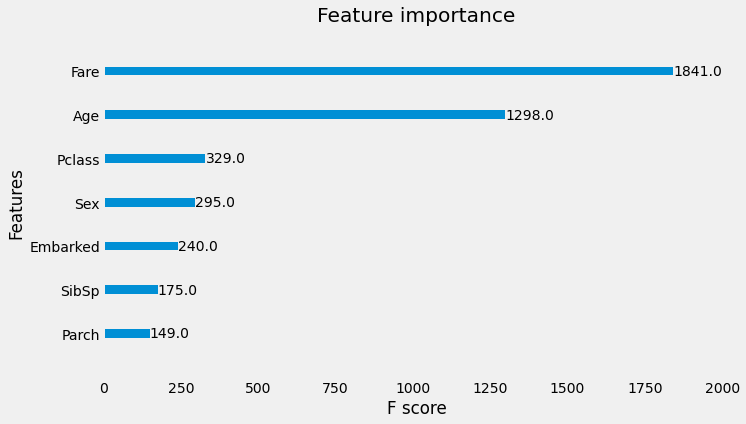

In [44]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, max_num_features=20, ax=ax, grid=False)
plt.show()

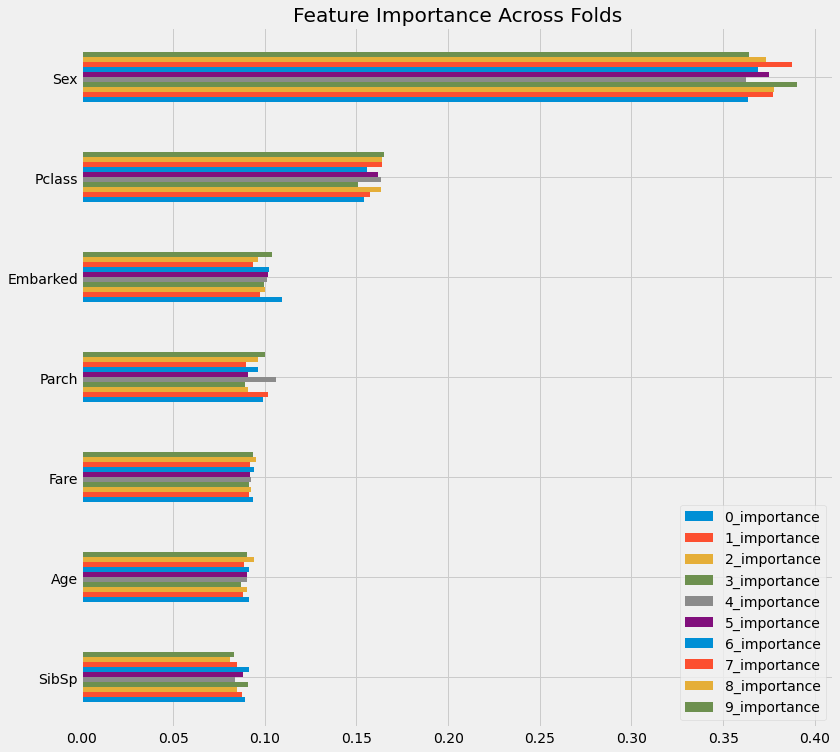

In [45]:
fis_df.sort_values("0_importance", ascending=True).tail(20).plot(
    kind="barh", figsize=(12, 12), title="Feature Importance Across Folds"
)
plt.show()

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Save OOF Predictions</h1>



In [46]:
pred_field = f"pred_{Config.model_name}"

final_valid_predictions_df = pd.DataFrame.from_dict(
    final_valid_predictions, orient="index"
).reset_index()

final_valid_predictions_df.columns = ["id", pred_field]

final_valid_predictions_df[pred_field] = final_valid_predictions_df[pred_field]

final_valid_predictions_df.to_csv(
    f"results/oof_preds_cv{cv_score:0.6f}_s{Config.seed}_k{Config.N_FOLDS}_{Config.model_name}.csv",
)

final_valid_predictions_df.head()

,id,pred_xgb1
0,25,0
1,29,1
2,32,1
3,35,1
4,44,1


<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Submission</h1>
</div>

In [47]:
np.column_stack(final_test_predictions)[:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [48]:
# mean_result = np.mean(np.column_stack(final_test_predictions), axis=1)  # .astype("int")
mode_result = mode(np.column_stack(final_test_predictions), axis=1)
type(mode_result)

scipy.stats.stats.ModeResult

In [49]:
result = mode_result[0].flatten()
result

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [50]:
message = f"{Config.model_name}_cv{cv_score:0.6f}_seed{Config.seed}_k{Config.N_FOLDS}_n{Config.N_ESTIMATORS}"
print(f"\nSubmit Message: {message}\n")

submission_df[TARGET] = result  # .astype("bool")

submission_df.to_csv(
    f"results/test_preds_cv:{cv_score:0.6f}_s:{Config.seed}_k:{Config.N_FOLDS}_{Config.model_name}.csv",
    index=False,
)
submission_df.to_csv("submission.csv", index=False)
submission_df.head(10)


Submit Message: xgb1_cv0.827129_seed42_k10_n100



,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
